In [2]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from collections import Counter
from functools import lru_cache

%matplotlib inline

In [3]:
from explib.utils import savepkl, loadpkl

In [4]:
from explib.models.glasso_opt import glasso, glasso_with_screening, quic, quic_with_screening
from explib.models.mgl_opt import solve_mgl

from explib._helper import *

from explib.math_utils import (count_edges, 
                               confusion_matrix, 
                               metrics_from_confusion, 
                               glasso_objective, 
                               check_random_state,
                               log_likelihood)

In [5]:
def generate_labels(n_nodes, n_classes, equal_size=True, random_state=0):
    random = check_random_state(random_state)
    label = np.full(n_nodes, -1, dtype=int)
    if equal_size:
        k = n_nodes // n_classes
        ## 漂亮的写法
        for i in range(n_classes):
            label[k*i:k*(i+1)] = i
        else:
            label[k*(i+1):] = i
    else:
        mat = random.rand(n_nodes, n_classes)
        label = np.sort(np.argmax(mat, axis=1))
    return label


def random_element_generator(random_state=0):
    random = check_random_state(random_state)
    while True:
        c = (random.rand() - .5) * .6
        c = np.sign(c) * (np.abs(c) + .1)
        yield c

        
def make_precision_matrix(labels, prob, random_state=0):
    random = check_random_state(random_state)
    random_gen = random_element_generator(random_state)
    # n个结点
    n = len(labels)
    # nb_classe个class
    nb_classes = len(set(labels))
    mat = np.zeros((n, n))
    # 按两结点label距离概率随机初始化mat
    for i in range(n):
        for j in range(i+1, n):
            ci = labels[i]
            cj = labels[j]
            if random.rand() < prob(np.abs(ci - cj), n, nb_classes):
                mat[i, j] = next(random_gen)
                mat[j, i] = mat[i, j]
    # positive definite
    # s = np.abs(mat).sum(axis=0)
    # mat /= (s * 1.5) ** .5
    # np.fill_diagonal(mat, 1.)
    mu = linalg.eigvalsh(mat)[0]
    np.fill_diagonal(mat, 1-mu)
    # covariance
    cov = np.linalg.inv(mat)
    d = cov.diagonal() ** .5
    cov /= d[None, :] * d[:, None]
    prec = np.linalg.inv(cov)
    return cov, prec


def make_prob_function(label, edges_ratio):
    # prepare necessary variables
    p = len(label)
    label_counter = Counter(label)
    nb_classes = len(label_counter)
    p_per_class = np.array([v for k, v in sorted(label_counter.items())])
    # outer 求外积
    edges_per_block = np.outer(p_per_class, p_per_class)
    np.fill_diagonal(edges_per_block, p_per_class * (p_per_class - 1) / 2)
    # prob_list
    @lru_cache(5)
    def prob(d, *args, **kwargs):
        d = abs(d)
        edges = edges_per_block.diagonal(d).sum()
        if d < len(edges_ratio):
            c = edges_ratio[d]
        else:
            c = .1
        return c * p / edges
    return prob


def make_sample_covariance(cov_mat, n_samples, random_state=0):
    p = cov_mat.shape[0]
    random = check_random_state(random_state)
    X = random.multivariate_normal(np.zeros(p), cov_mat, size=n_samples)
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    emp_cov = X.T @ X / n_samples
    return emp_cov
        

    
def metrics_for_tensor(true_prec_list, pred_prec_list, tol=1e-8):
    target_edges = np.sum([count_edges(x) for x in true_prec_list])
    n_edges = np.sum([count_edges(x, tol) for x in pred_prec_list])
    conf_mat = np.zeros((2, 2))
    for prec_true, prec_pred in zip(true_prec_list, pred_prec_list):
        conf_mat += confusion_matrix(prec_true, prec_pred, tol)
    recall = metrics_from_confusion(conf_mat)
    return target_edges, n_edges, recall


def label_vec2mat(label, n_classes):
    p = len(label)
    label_mat = np.zeros((p, n_classes))
    valid_idx = (label >= 0) & (label < len_life_cycle)
    valid_label = label[valid_idx]
    # 漂亮的写法
    label_mat[valid_idx, valid_label] = 1.
    return label_mat

In [6]:
def multi_log_likelihood(S_list, X_list):
    v = 0.
    for S, X in zip(S_list, X_list):
        v += log_likelihood(S, X)
    return v

[array([[ 1.        , -0.03053468,  0.03964821, ...,  0.00888107,
        -0.01661286,  0.00595985],
       [-0.03053468,  1.        ,  0.01723692, ...,  0.00345631,
         0.04373796, -0.02691239],
       [ 0.03964821,  0.01723692,  1.        , ..., -0.00534647,
        -0.04943501,  0.00852415],
       ...,
       [ 0.00888107,  0.00345631, -0.00534647, ...,  1.        ,
         0.09022789,  0.07210613],
       [-0.01661286,  0.04373796, -0.04943501, ...,  0.09022789,
         1.        , -0.03142612],
       [ 0.00595985, -0.02691239,  0.00852415, ...,  0.07210613,
        -0.03142612,  1.        ]]), array([[ 1.        ,  0.02345419,  0.0416109 , ...,  0.02024359,
        -0.02756168, -0.12778414],
       [ 0.02345419,  1.        , -0.02640074, ..., -0.06491633,
         0.01817746, -0.04622021],
       [ 0.0416109 , -0.02640074,  1.        , ...,  0.00798117,
         0.06345152, -0.0412264 ],
       ...,
       [ 0.02024359, -0.06491633,  0.00798117, ...,  1.        ,
        

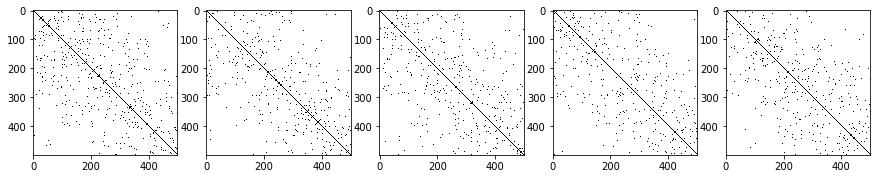

In [10]:
# generate ground truth data
random_state = 0
len_life_cycle = 5
K = 5
invalid_stages = 0
p = 500

# p, len_life_cycle, K = 1000, 3, 10


label = generate_labels(p, len_life_cycle + invalid_stages, equal_size=True, random_state=random_state)
label -= invalid_stages

# 不同偏移量的对角线之和的门槛 ？？？
edge_ratio = np.array([4, 3, 2]) / 2
cov_list = []
prec_list = []
label_list = []
for k in range(K):
    random_state += 1
    label = generate_labels(p, len_life_cycle + invalid_stages, equal_size=True, random_state=random_state)
    
    full_cov = np.identity(p)
    full_prec = np.identity(p)
    
    valid_idx = (label >= 0) & (label < len_life_cycle)
    valid_label = label[valid_idx]
    # 确定留边比例
    prob_func = make_prob_function(valid_label, edge_ratio)
    # ground truth 的cov和prec matrix
    cov, prec = make_precision_matrix(valid_label, prob_func, random_state)
    # 确保在 life_cycle 内
    full_cov[np.ix_(valid_idx, valid_idx)] = cov
    full_prec[np.ix_(valid_idx, valid_idx)] = prec
    
    cov_list.append(full_cov)
    prec_list.append(full_prec)
    label_list.append(label.copy())
#     label += 1
# label_list: K * p

# emp_cov_list: K * (p * p)

# generate test data ?
'''def make_sample_covariance(cov_mat, n_samples, random_state=0):'''
emp_cov_list = [make_sample_covariance(cov_mat, p) for cov_mat in cov_list]
print(emp_cov_list)

# label_mat_list: K * (p * n_class)
label_mat_list = [label_vec2mat(x, len_life_cycle) for x in label_list]

_ = show_tensor(prec_list)

In [8]:
'''
def label_vec2mat(label, n_classes):
    p = len(label)
    label_mat = np.zeros((p, n_classes))
    valid_idx = (label >= 0) & (label < len_life_cycle)
    valid_label = label[valid_idx]
    label_mat[valid_idx, valid_label] = 1.
    return label_mat'''
print(label_mat_list[0])
label = label_list[0]
p = len(label)
label_mat = np.zeros((p, 5))
valid_idx = (label >= 0) & (label < len_life_cycle)
valid_label = label[valid_idx]
label_mat[valid_idx, valid_label] = 1.
label_mat

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

52
3486.9536733847162
3486.080665589002
3486.080069560972
------
------
Norm of U: 13.155983650177696
Log-likelihood: -3542.781203344516
compare:  (11646, 4018, (0.9764488977955912, 0.1212045793927327, 0.04181693285248154, 0.062180796731358526))


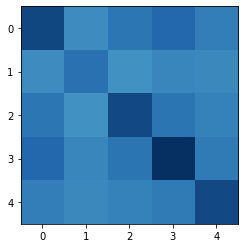

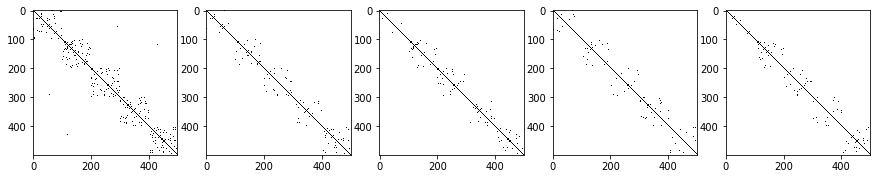

In [9]:
# calculate prediction
seed = np.random.randint(0, 100)
print(seed)

with np.errstate(all='raise'):
# emp_cov_list is the sample covariance matrix.
# Ak is the i-th variable’s attributes in the k-th task
    X_list, U, fvals = solve_mgl(emp_cov_list, label_mat_list,
                                 d=100, 
                                 lambda_1=.2,
                                 lambda_2=.04,
                                 beta=.01,
                                 outer_max_it=20,
                                 outer_tol=1e-4,
                                 seed=seed)
    

K = U @ U.T
vmax = np.abs(K).max()
plt.imshow(K, cmap='RdBu', vmax=vmax, vmin=-vmax)

X_filtered_list = [X.copy() for X in X_list]
for X in X_filtered_list:
    X[np.isclose(X_list[0], 0, atol=.04)] = 0
    pass
print('------')
show_tensor(X_filtered_list)
print('------')
print('Norm of U: {}'.format(np.linalg.norm(U, 'fro')))
print('Log-likelihood: {}'.format(multi_log_likelihood(emp_cov_list, X_filtered_list)))
print('compare: ', metrics_for_tensor(prec_list, X_filtered_list))

Norm of U: 12.533189926313954
Log-likelihood: -3542.7445556486537
--------
(11646, 4019, (0.9764633266533066, 0.12241851206767852, 0.0422462648119526, 0.06281519310564954))
500 5


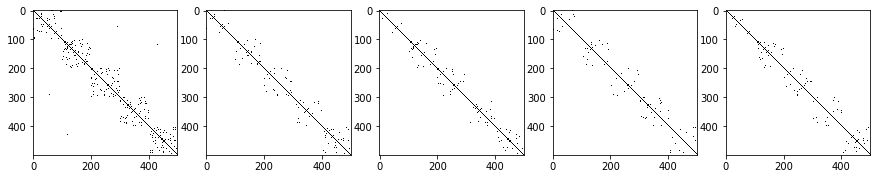

In [9]:
'''
def metrics_for_tensor(true_prec_list, pred_prec_list, tol=1e-8):
    target_edges = np.sum([count_edges(x) for x in true_prec_list])
    n_edges = np.sum([count_edges(x, tol) for x in pred_prec_list])
    conf_mat = np.zeros((2, 2))
    for prec_true, prec_pred in zip(true_prec_list, pred_prec_list):
        conf_mat += confusion_matrix(prec_true, prec_pred, tol)
    recall = metrics_from_confusion(conf_mat)
    return target_edges, n_edges, recall
'''


show_tensor(X_filtered_list)
print('Norm of U: {}'.format(np.linalg.norm(U, 'fro')))
print('Log-likelihood: {}'.format(multi_log_likelihood(emp_cov_list, X_filtered_list)))
print('--------')
print(metrics_for_tensor(prec_list, X_filtered_list))
# prec_list 500 * 500
# prec_list 是 ground_truth ;; X_filtered_list 是
print(len(prec_list[0]), len(X_filtered_list))